In [2]:
from skimage.io import imsave, imshow, show
import numpy as np
from tqdm import tqdm_notebook
from skimage.feature import hog
from keras.datasets import cifar100
from skimage import data, exposure, color
import cv2
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
people_labels_id = ['man', 'woman']

Категории датасета

In [4]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

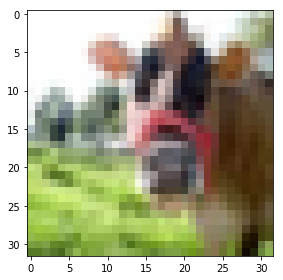

In [5]:
imshow(x_train[0])
show()

Выберим изображения лиц мужчин и женщин, а также всех остальных категорий по 8 изображений

In [7]:
pidx = [CIFAR100_LABELS_LIST.index(label) for label in people_labels_id]

man = x_train[y_train.flatten() == 46]
woman = x_train[y_train.flatten() == 98]

people_dataset = np.vstack((man, woman))
people_labels = np.ones(people_dataset.shape[0]).reshape(-1, 1)

non_people_dataset = []

for label in range(len(CIFAR100_LABELS_LIST)):
    if label not in pidx:
        label_dataset = x_train[y_train.flatten() == label][:8]
        non_people_dataset.append(label_dataset)



non_people_dataset = np.array(non_people_dataset)
sh1 = non_people_dataset.shape[0]
sh2 = non_people_dataset.shape[1]
non_people_dataset = non_people_dataset.reshape(sh1 * sh2, 32, 32, 3)
non_people_labels = np.zeros(non_people_dataset.shape[0]).reshape(-1, 1)

dataset = np.vstack((people_dataset, non_people_dataset))
labels = np.vstack((people_labels, non_people_labels))

In [8]:
dataset = [color.rgb2gray(i) for i in dataset]

В качестве признаков - вектор HOG

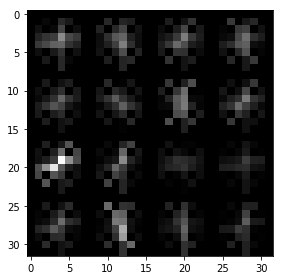

In [9]:
H, hogImage = hog(dataset[0], orientations=9, pixels_per_cell=(8, 8),
    cells_per_block=(4, 4), transform_sqrt=True, visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
hogImage = hogImage.astype("uint8")
imshow(hogImage)
show()

In [10]:
X_ = []
for i, img in tqdm_notebook(enumerate(dataset)):
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(4, 4),  transform_sqrt=True, visualise=True)
    X_.append(fd)
X = np.array(X_)
y = labels
X = preprocessing.scale(X)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Проведем декомпозицию данных методом PCA и построим на графике первые две главные компоненты

Дисперсия первых двух главных компонент: [0.06210672 0.03609353]


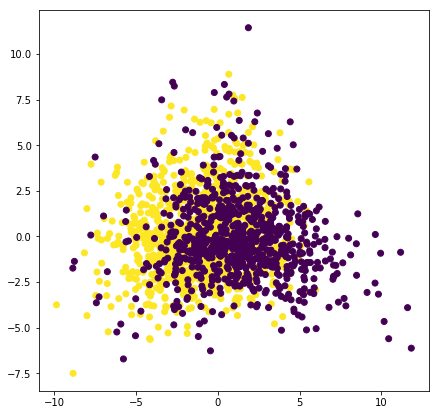

In [12]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

print('Дисперсия первых двух главных компонент: {}'.format(pca.explained_variance_ratio_))
colors = y.flatten()
one_c = colors == 1
plt.figure(figsize=[7,7])
plt.scatter(pca_result[:,0][:], pca_result[:, 1][:], c=colors[:])
plt.show()

Применим логистическую регрессию, т.к. данные частично линейно разделимы

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(C=0.01)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probs = model.predict_proba(X_test)

print('Точность классификатор {}'.format(accuracy_score(y_test, prediction))) 
print('ROC-score {}'.format(roc_auc_score(y_test, probs[:, 1])))

Точность классификатор 0.7703081232492998
ROC-score 0.8048116492560935


Теперь для двух первых главных копмонент

In [23]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, y, test_size=0.2, random_state=42)

model = LogisticRegression(C=0.01)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
probs = model.predict_proba(X_test)

print('Точность классификатор {}'.format(accuracy_score(y_test, prediction))) 
print('ROC-score {}'.format(roc_auc_score(y_test, probs[:, 1])))

Точность классификатор 0.7030812324929971
ROC-score 0.7530864197530865


Точность упала незначительно (на 7%)

Разделительная прямая

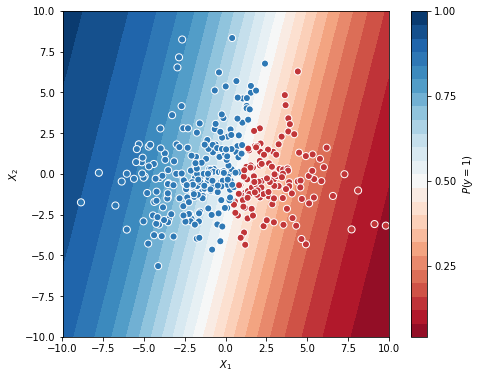

In [24]:
xx, yy = np.mgrid[-10:10:.01, -10:10:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)


f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[:,0], X_test[:, 1], c=prediction[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-10, 10), ylim=(-10, 10),
       xlabel="$X_1$", ylabel="$X_2$")
plt.show()

# Вывод 

В качестве признакового пространства использовался вектор HOG. Классификатором была логистическая регрессия. В процессе обучения настраивался параметр С (регуляризация) и мараметры HOG: пикселей на клетку и клеток на блок. Другие классификаторы показали себя хуже (СВМ и случайный лес). ЛУчший запуск - 77% худший (СВМ) - 65%